# Data Preparation for All-Star Game MVP

In this notebook we will prepare the data for the All-Star Game MVP prediction.

#### Load Dependencies

In [63]:
import sys
import os
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('..')

from data_scripts import _store_data as sd
from pathlib import Path

sd.load_data(Path("../data"))

#### Copy and Prepare Player Data

This section prepares player performance statistics for All-Star Game MVP analysis:

- **Copy Dataset:** Create a copy of the original player-team dataset to preserve the source data.  
- **Convert Key Stats to Float:** Ensure important performance statistics are numeric for accurate calculations.  
- **Aggregate by Player and Year:** Group the data by player and year, summing stats to get yearly totals per player.  
- **Add Season 11 Data:** Include additional data from Season 11 for completeness.  
- **Sort Data:** Organize the aggregated data by player and year for multi-year computations.

In [64]:
allstar_game_mvp_info_df = sd.players_teams_df.copy()

cols_to_agg = ['points', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'fgMade', 'fgAttempted', 'GP']

for col in cols_to_agg:
    allstar_game_mvp_info_df[col] = allstar_game_mvp_info_df[col].astype(float)

allstar_game_mvp_info_df = allstar_game_mvp_info_df.groupby(['playerID', 'year'], as_index=False)[cols_to_agg].sum()

# Adding data from Season 11
players_teams_year11_df = pd.read_csv("../basketballPlayoffs/Season_11/players_teams.csv")

allstar_game_mvp_info_df = pd.concat([allstar_game_mvp_info_df, players_teams_year11_df[['playerID', 'year']]], ignore_index=True)

allstar_game_mvp_info_df = allstar_game_mvp_info_df.sort_values(['playerID', 'year'])

#### Compute Overall Performance Score Function

This section defines a function to calculate an overall performance score for each player per season:

- **Normalize by Games Played:** Adjust statistics to account for differences in games played.  
- **Weight Key Stats:** Apply weights to points, rebounds, assists, steals, blocks, turnovers, and field goal percentage to reflect their impact on overall performance.  
- **Compute Overall Score:** Combine the weighted stats into a single performance score for each player per season.

In [65]:
def overall_performance(PTS, REB, AST, STL, BLK, TOV, FGM, FGA, GP):
    if GP == 0 or FGA == 0:
        return 0 
    FG_percent = FGM / FGA
    return (
        (PTS / GP) +
        (REB / GP) * 1.2 +
        (AST / GP) * 1.5 +
        (STL / GP) * 3 +
        (BLK / GP) * 2 -
        (TOV / GP) * 2 +
        FG_percent * 10
    )

#### Calculate Multi-Year Performance Scores

This section computes multi-year performance scores for each player:

- **Previous Seasons:** Calculate performance scores for the past 1, 2, and 3 years.  
- **Use `overall_performance` Function:** Apply the function to generate per-season performance scores.  
- **Create Lagged Features:** Generate lagged statistics to capture trends over multiple seasons, useful for predictive modeling.

In [66]:
for shift_years in [1, 2, 3]:
    col_suffix = f"prev_{shift_years}yr"

    
    shifted_points = allstar_game_mvp_info_df.groupby('playerID')['points'].shift(shift_years)
    shifted_assists = allstar_game_mvp_info_df.groupby('playerID')['assists'].shift(shift_years)
    shifted_turnovers = allstar_game_mvp_info_df.groupby('playerID')['turnovers'].shift(shift_years)
    shifted_fgMade = allstar_game_mvp_info_df.groupby('playerID')['fgMade'].shift(shift_years)
    shifted_fgAttempted = allstar_game_mvp_info_df.groupby('playerID')['fgAttempted'].shift(shift_years)
    shifted_gp = allstar_game_mvp_info_df.groupby('playerID')['GP'].shift(shift_years)
    shifted_rebounds = allstar_game_mvp_info_df.groupby('playerID')['rebounds'].shift(shift_years)
    shifted_steals = allstar_game_mvp_info_df.groupby('playerID')['steals'].shift(shift_years)
    shifted_pf = allstar_game_mvp_info_df.groupby('playerID')['blocks'].shift(shift_years)

    
    overall_performance_scores = pd.Series(
        [overall_performance(
            shifted_points.iloc[i], shifted_rebounds.iloc[i], shifted_assists.iloc[i],
            shifted_steals.iloc[i], shifted_pf.iloc[i], shifted_turnovers.iloc[i],
            shifted_fgMade.iloc[i], shifted_fgAttempted.iloc[i], shifted_gp.iloc[i])
         for i in range(len(allstar_game_mvp_info_df))],
        index=allstar_game_mvp_info_df.index
    )
    
    allstar_game_mvp_info_df[f'overall_score_{col_suffix}'] = overall_performance_scores.fillna(0)

#### Merge All-Star Game MVP Award Information

This step incorporates the target variable for modeling All-Star Game MVP performance:

- **Filter Awards:** Identify All-Star Game MVP awards from the awards dataset.  
- **Add Indicator:** Create a column marking winners (1) or non-winners (0).  
- **Merge with Players:** Combine award data with the player dataframe.  
- **Prepare for Modeling:** Ensure the dataset includes features and the target variable.

In [67]:
allstar_game_mvp_aw = sd.awards_players_df[sd.awards_players_df['award'].str.strip().str.lower() == 'all-star game most valuable player'].copy()
allstar_game_mvp_aw['allstar_mvp'] = 1

allstar_game_mvp_info_df = allstar_game_mvp_info_df.merge(
    allstar_game_mvp_aw[['playerID', 'year', 'allstar_mvp']],
    on=['playerID', 'year'],
    how='left'
)
allstar_game_mvp_info_df['allstar_mvp'] = allstar_game_mvp_info_df['allstar_mvp'].fillna(0).astype(int)

#### Remove Columns and Save CSV

This step finalizes the All-Star Game MVP dataset:

- **Drop Unnecessary Columns:** Remove raw stats and irrelevant features to focus on key data.  
- **Save to CSV:** Export the processed dataset to a CSV file for predictive modeling.  
- **Ready for Analysis:** The dataset is now clean and contains features for All-Star Game MVP prediction.

In [68]:
cols_to_drop = ['points', 'rebounds', 'assists', 'steals', 'blocks', 
                'turnovers', 'fgMade', 'fgAttempted', 'GP']

allstar_game_mvp_info_df = allstar_game_mvp_info_df.drop(
    columns=[col for col in cols_to_drop if col in allstar_game_mvp_info_df.columns]
)

allstar_game_mvp_info_df.to_csv("../predict_datasets/all-star_game_mvp.csv", index=False)

#### Idea For the Dataset Preparation

Since this dataset is for All-Star most valuable player dataset, we calculated the overall performance score for each player, as the best players are typically chosen for the game. Given that no additional data was available that we believed would meaningfully improve prediction accuracy, we relied solely on the player score for our analysis.

#### Data Correlation Analysis

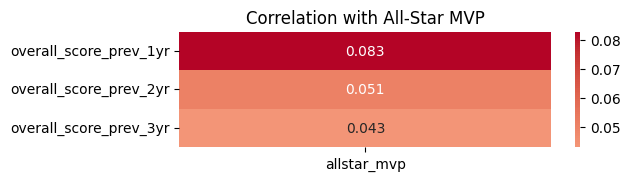

In [69]:
score_cols = ['overall_score_prev_1yr', 'overall_score_prev_2yr', 'overall_score_prev_3yr', 'allstar_mvp']
df_scores = allstar_game_mvp_info_df[score_cols]

corr_matrix = df_scores.corr()[['allstar_mvp']]

corr_matrix = corr_matrix.drop('allstar_mvp')

plt.figure(figsize=(6, len(corr_matrix)/2))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation with All-Star MVP")
plt.show()